### Some imports

In [1]:
import time
import math
import decimal
from pandas import DataFrame
from decimal import Decimal as dec
import seaborn as sns
import numpy as np
from numpy import random as np_rnd
from scipy.stats.distributions import norm
import random as rnd
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from IPython.display import Latex

%matplotlib inline

### Some constants

In [2]:
EPSILON = .001

## I. One-dimensional methods
### Minimization functions

In [3]:
def exhaustive_search(function, interval):
    """Brute-force algorithm"""
    calls, iterations = 0, 0
    # not counted function call
    # made for ease of coding
    minimal_value = function(interval[0])
    
    for x in np.arange(*interval, EPSILON):
        y = function(x)
        calls += 1
        
        if y < minimal_value:
            minimal_value = y
            
        iterations += 1
    return minimal_value, calls, iterations


def bisection(function, interval):
    """Dichotomy algorithm"""
    calls, iterations = 0, 0
    
    a, b = interval
    while abs(b - a) > EPSILON:
        x = (a + b) /2
        
        if function(x - EPSILON) < function (x + EPSILON):
            b = x
        else:
            a = x
            
        calls += 2
        iterations += 1
        
    # not counted function call
    # made for ease of coding
    return function(a), calls, iterations

def golden_section(function, interval):
    """Golden section algorihm"""
    calls, iterations = 0, 0
    phi = (1 + math.sqrt(5)) / 2
    
    a, b = interval
    
    c = b - (b - a) / phi
    d = a + (b - a) / phi
    f_c, f_d, last_shift_right = None, None, None
    
    while abs(b - a) > EPSILON:
        if last_shift_right is None:
            f_c = function(c)
            f_d = function(d)
            calls += 1
        elif last_shift_right:
            f_d = function(d)
        else:
            f_c = function(c)
        calls += 1
        
        if f_c < f_d:
            b = d
            last_shift_right = False
            f_d = f_c
        else:
            a = c
            last_shift_right = True
            f_c = f_d
            
        # recalculate values to minimize loss of percision
        c = b - (b - a) / phi
        d = a + (b - a) / phi
            
        iterations += 1
    
    # last call in return statement
    # is not counted as another iteration
    return function((a + b) / 2), calls + 1, iterations

### Functions to minimize

In [4]:
cubic_function = lambda x: x * x * x

abs_function = lambda x: abs(x - 0.2)

sin_function = lambda x: x * math.sin(1 / x)

### Measurements
Some setup rules and measurement function

In [5]:
columns = ["Method", "minimum", "function calls", "iterations"]
minimizators = [exhaustive_search, bisection, golden_section]
function_setups = {cubic_function: (0, 1), abs_function: (0, 1), sin_function: (0.01, 1)}

measure_function = lambda function:\
    [(minimizator.__name__, *minimizator(function, function_setups[function])) for minimizator in minimizators]

Measurements
1. Cubic function<br>
$f(x)=x^3, x\in[0,1]$

In [6]:
cubic_function_table = DataFrame.from_records(measure_function(cubic_function))
cubic_function_table.columns = columns
display(cubic_function_table)

,Method,minimum,function calls,iterations
0,exhaustive_search,0.000000e+00,1000,1000
1,bisection,0.000000e+00,20,10
2,golden_section,4.925680e-11,17,15


2. Absolute value function<br>
$f(x)=|x-0.2|, x\in[0,1]$

In [7]:
abs_function_table = DataFrame.from_records(measure_function(abs_function))
abs_function_table.columns = columns
display(abs_function_table)

,Method,minimum,function calls,iterations
0,exhaustive_search,0.000000,1000,1000
1,bisection,0.000781,20,10
2,golden_section,0.000073,17,15


3. Sinus funcion<br>
$f(x)=x \sin(\frac{1}{x}), x\in[0.01, 1]$

In [8]:
sin_function_table = DataFrame.from_records(measure_function(sin_function))
sin_function_table.columns = columns
display(sin_function_table)

,Method,minimum,function calls,iterations
0,exhaustive_search,-0.217225,990,990
1,bisection,-0.217204,20,10
2,golden_section,-0.217232,17,15


## II. Multidimensional methods

### Setup

In [9]:
alpha, beta = rnd.uniform(0, 1), rnd.uniform(0, 1)

X = [k / 100 for k in range(0, 101)]
delta = norm(loc=0, scale=1).rvs(size=101)
Y = [alpha * x_k + beta + delta_k for x_k, delta_k in zip(X, delta)]

<AxesSubplot:>

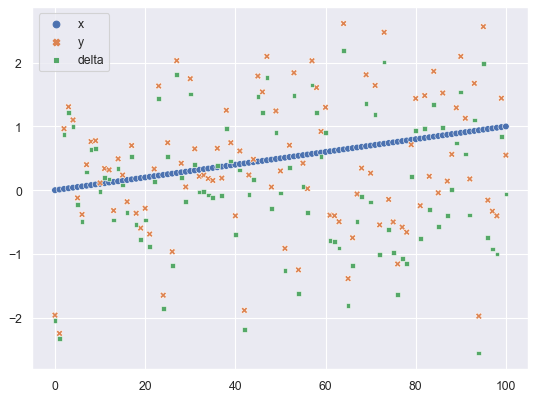

In [10]:
noise = DataFrame({"x":X,"y":Y,"delta":delta})
sns.set_theme()
plt.figure(figsize=(8, 6), dpi=80)
sns.scatterplot(data=noise)

<AxesSubplot:xlabel='y', ylabel='Count'>

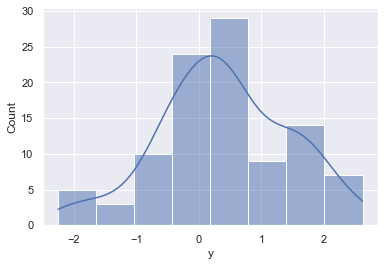

In [11]:
sns.histplot(data=noise, x="y", kde=True)

### Approximants

In [12]:
linear_approximant = lambda x, a, b: a * x + b
rational_approximant = lambda x, a, b: a / (1 + b * x)

### Function to minimize
least squares method

In [13]:
least_squares = lambda function, a, b: \
    sum([math.pow(function(x_k, a, b) - y_k, 2) for x_k, y_k in zip(X, Y)])

### Minimization functions

In [14]:
def multidim_exhaustive_search(function, ranges):
    calls, iterations = 0, 0
    
    min_value = None
    x_m, y_m = 0, 0
    for x in np.arange(ranges[0][0], ranges[0][1], step=EPSILON):
        for y in np.arange(ranges[1][0], ranges[1][1], step=EPSILON):
            value = least_squares(function, x, y)
            calls += 1
            
            if min_value is None or value < min_value:
                min_value = value
                x_m, y_m = x, y
            iterations += 1
    
    return [x_m, y_m], min_value, calls, iterations

def gauss_search(function,  ranges):
    calls, iterations = 0, 0
    previous_result = None
    x_iteration = True
    other_coord = np.random.choice(np.arange(ranges[1][0], ranges[1][1], EPSILON))
    
    
    while True:
        dimension = 0 if x_iteration else 1
        # value of function
        current_minimum = None
        # value of iterated coord
        current_minima = None

        for i in np.arange(ranges[dimension][0], ranges[dimension][1], step=EPSILON):
            iterations += 1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
            value = least_squares(function, i, other_coord) \
                if x_iteration \
                else least_squares(function, other_coord, i)
            calls += 1
            
            if current_minimum is None or value < current_minimum:
                current_minimum, current_minima = value, i
                
        current_result = np.array([current_minima, other_coord]) \
            if x_iteration \
            else np.array([other_coord, current_minima])
        
        if previous_result is not None and abs(previous_result[dimension] - current_result[dimension]) < EPSILON:
            return current_result, current_minimum, calls, iterations
            break

        previous_result = current_result
        other_coord = current_minima
        x_iteration = not x_iteration

    
def nelder_mead(function, ranges):
    f = lambda x: least_squares(function, *x)
    
    calls, iterations = 0, 0
    _alpha, _beta, _gamma = 1.5, 0.75, 3
    difference = EPSILON + 1
    
    # choose three points with random coordinates
    x1, x2, x3 = [[rnds[0] * (ranges[0][1] - ranges[0][0]) + ranges[0][0], \
                   rnds[1] * (ranges[1][1] - ranges[1][0]) + ranges[1][0]] \
                  for rnds in np_rnd.ranf((3,2))]
    
    d1, d2, d3 = sorted([{'x': x1, 'y': f(x1)}, \
                         {'x': x2, 'y': f(x2)}, \
                         {'x': x3, 'y': f(x3)}], \
                        key=lambda x: x['y'])
    calls += 3
    x_h, x_g, x_l = np.array(d3['x']), np.array(d2['x']), np.array(d1['x'])
    f_h, f_g, f_l = d3['y'], d2['y'], d1['y']
    
    def compress(xh, xc):
        xs = _beta * xh + (1 - _beta) * xc
        fs = f(xs)
        return xs, fs
    
    while difference > EPSILON:
        iterations += 1
        
        # center of mass
        x_c = (x_g + x_l) / 2
        # reflection of x_h
        x_r = (1 + _alpha) * x_c - _alpha * x_h
        f_r = f(x_r)
        calls += 1

        if f_r < f_l:
            x_e = (1 - _gamma) * x_c + _gamma * x_r
            f_e = f(x_e)
            calls += 1

            if f_e < f_r:
                x_h, f_h = x_e, f_e
            else:
                x_h, f_h = x_r, f_r

        elif f_r < f_g:
            x_h, f_h = x_r, f_r

        else:
            if f_r < f_h:
                # exchange values
                x_r, x_h = x_h, x_r
                f_r, f_h = f_h, f_r

            x_s, f_s = compress(x_h, x_c)
            calls += 1
            if f_s < f_h:
                x_h, f_h = x_s, f_s
            else:
                x_h, x_g = [x_l + (x - x_l) / 2 for x in [x_h, x_g]]

        [x_l, f_l], [x_g, f_g], [x_h, f_h]  = \
            sorted([[x_h, f_h], [x_g, f_g], [x_l, f_l]], key=lambda x: x[1])
        
        difference = max(np.std([x_l, x_g, x_h], axis=0))
    
    return x_l, f_l, calls, iterations


### Help function
for displaying measurement results

In [36]:
def visualize_measurements(func, exh_res, gauss_res, nelder_res, lg_loc='upper right'):
    fig, ax = plt.subplots()
    plt.figure(figsize=(8,6))
    applied_approximant = lambda x, y: least_squares(func, x, y)
    
    results = DataFrame.from_records([exh_res,gauss_res,nelder_res], columns=["x", "result", "calls", "iterations"])

    x_range = [min(results["x"], key=lambda i: i[0])[0], max(results["x"], key=lambda i: i[0])[0]]
    y_range = [min(results["x"], key=lambda i: i[1])[1], max(results["x"], key=lambda i: i[1])[1]]

    # extend ranges
    x_range_third = (x_range[1] - x_range[0]) / 3
    x_grid = np.linspace(x_range[0] - x_range_third, x_range[1] + x_range_third, 100)

    y_range_third = (y_range[1] - y_range[0]) / 3
    y_grid = np.linspace(y_range[0] - y_range_third, y_range[1] + y_range_third, 100)
    value_grid = [[applied_approximant(x, y) for y in y_grid] for x in x_grid]

    chart = ax.contourf(x_grid, y_grid, value_grid, cmap="YlGnBu", levels=10)

    labels = ['approximant', '(r)-exhausive search','(g)-gauss search','(b)-nelder mead']
    for i in range(len(labels)):
        chart.collections[i].set_label(labels[i])

    ax.legend(loc=lg_loc)
    ax.plot(exh_res[0][0], exh_res[0][1], 'ro')
    ax.plot(gauss_res[0][0], gauss_res[0][1], 'go')
    ax.plot(nelder_res[0][0], nelder_res[0][1], 'bo')
    
def visualize_resulting_lines(func, exh_res, gauss_res, nelder_res):
    x = np.linspace(-10, 10, 100)
    y_exh = [func(x_i, exh_res[0][0], exh_res[0][1]) for x_i in x]
    y_gauss = [func(x_i, gauss_res[0][0], gauss_res[0][1]) for x_i in x]
    y_nelder = [func(x_i, nelder_res[0][0], nelder_res[0][1]) for x_i in x]
    
    plot(x, y_exh, 'r.-', label="Exhaustive")
    plot(x, y_gauss, 'g-', label="Gauss")
    plot(x, y_nelder, 'b--', label="Nelder-Mead")
    plot(np.linspace(-10, 10, 101), Y, 'yo', label='Data')
    plt.legend()

### Setup

In [16]:
ranges = [[0,1],[0,1]]
ranges_rat = [[0,1],[-0.9999,0]]

### Measurements
1. linear approximant

In [17]:
exh = multidim_exhaustive_search(linear_approximant, ranges)
gauss = gauss_search(linear_approximant, ranges)
nelder = nelder_mead(linear_approximant, ranges)

In [18]:
linear_results = DataFrame.from_records([\
                                         ["Exhaustive", *exh[1:]],\
                                         ["Gauss", *gauss[1:]],\
                                         ["Nelder-Mead", *nelder[1:]]], \
                                        columns=["method","result", "calls", "iterations"])
display(linear_results)

,method,result,calls,iterations
0,Exhaustive,106.519658,1000000,1000000
1,Gauss,106.519696,30000,30000
2,Nelder-Mead,106.519708,101,51


As shown on the table, results differ letter then $\epsilon=0.001$
<br><br>
Areas with letter values are colored in lighter colors on the chart below

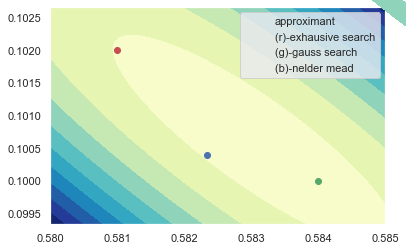

<Figure size 576x432 with 0 Axes>

In [19]:
visualize_measurements(linear_approximant, exh, gauss, nelder)

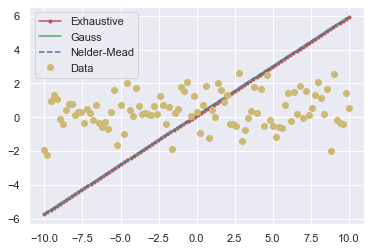

In [37]:
visualize_resulting_lines(linear_approximant, exh, gauss, nelder)

2. rational approximant

In [38]:
exh_rat = multidim_exhaustive_search(rational_approximant, ranges_rat)
gauss_rat = gauss_search(rational_approximant, ranges_rat)
nelder_rat = nelder_mead(rational_approximant, ranges_rat)

In [39]:
rat_results = DataFrame.from_records([\
                                         ["Exhaustive", *exh_rat[1:]],\
                                         ["Gauss", *gauss_rat[1:]],\
                                         ["Nelder-Mead", *nelder_rat[1:]]], \
                                        columns=["method","result", "calls", "iterations"])
display(rat_results)

,method,result,calls,iterations
0,Exhaustive,107.331387,1000000,1000000
1,Gauss,107.331469,25000,25000
2,Nelder-Mead,107.331452,103,52


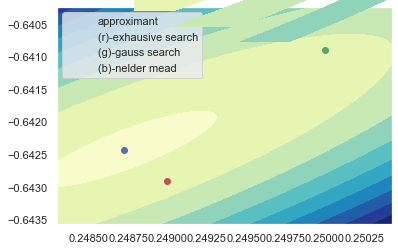

<Figure size 576x432 with 0 Axes>

In [40]:
visualize_measurements(rational_approximant, exh_rat, gauss_rat, nelder_rat, lg_loc='upper left')

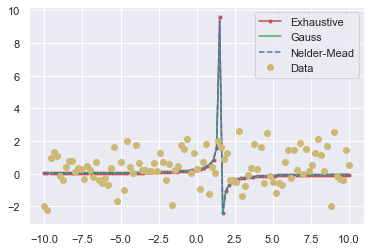

In [41]:
visualize_resulting_lines(rational_approximant, exh_rat, gauss_rat, nelder_rat)

In [63]:
a = [1,2,3]
b = [0, *a[1:]]
b

[0, 2, 3]